## Bayesian Optimisation Verification

In [1]:
# import relevant packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
# stop showing warning messages
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
# Setup data for training and evaluation
X_ = np.linspace(0,5000, 5000)
# import timestamp from data sheet (time:0~5000s) 
address = 'data/degradation.xlsx'
df_time = X_
# import data sheet at 85 C (time:0~5000s) 
df = pd.read_excel(address,sheet_name = 'normal data',usecols = [3],names = None,nrows = 5000)
df_85 = df.values.tolist() 
df = pd.read_excel(address,sheet_name = 'smooth data',usecols = [3],names = None,nrows = 5000)
df_85s = df.values.tolist()
# Format date into numpy array format
y_normal = np.array(df_85).T 
y_normal = y_normal.reshape((5000))
x_normal = X_
x_7_5000 = np.array([0,99,999,1999,2999,3999,4999])

In [39]:
# Plot function to show performance of gp prediction
def plot_performance(list_NOISE_LEVEL,performance_parameter):
    plt.figure()
    plt.plot(list_NOISE_LEVEL, performance_parameter, c='blue', lw=2, zorder=3)
    plt.scatter(list_NOISE_LEVEL, performance_parameter, c='red', s=10, zorder=4)
    plt.xscale('log')
    plt.tick_params(axis='y', colors = 'white')
    plt.tick_params(axis='x', colors = 'white')
    plt.ylabel('Performance parameter',color = 'white')
    plt.xlabel('Number of data points',color = 'white')
    # plt.ylim(0,0.00001)
    # plt.title('Performance of gp',color ='white')
    plt.tight_layout()
    plt.show()

In [44]:
# Plot function to show confidence bounds 
def plot(X_,y_normal,X,y_mean, sigma,gp):
    plt.figure()
    plt.plot(X_, y_mean, c='blue', lw=1, zorder=4, label='Prediction')
    plt.scatter(X[:, 0], Y, c='r', s=5, zorder=3,label='Trained data')
    plt.fill_between(X_, y_mean - 1.9600 * sigma,y_mean + 1.9600 * sigma,
                        alpha=0.5,color='grey',zorder=1, label='95% confidence interval')
    plt.scatter(X_,y_normal,c='lightblue',s=1,zorder=2, label='Experiment data')
    plt.tick_params(axis='y', colors = 'white')
    plt.tick_params(axis='x', colors = 'white')
    plt.ylabel('Lifetime',color = 'white')
    plt.xlabel('Time',color = 'white')
    plt.title("Initial: %s\nOptimum: %s\nLog marginal likelihood: %s" % 
                (kernel, gp.kernel_,gp.log_marginal_likelihood(gp.kernel_.theta)),
                color ='white')
    plt.legend()
    plt.tight_layout()
    plt.show()

Number of data points used: 5


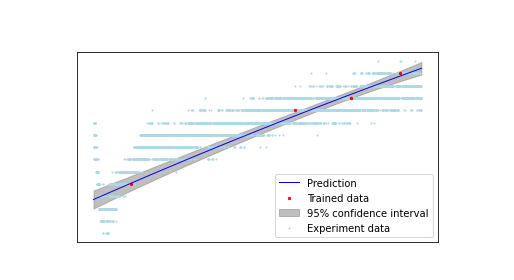

Number of data points used: 10


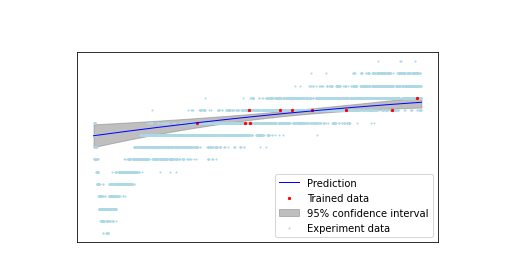

Number of data points used: 15


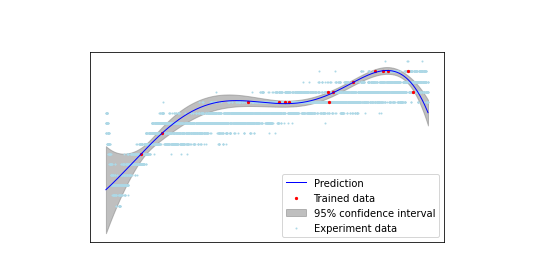

Number of data points used: 20


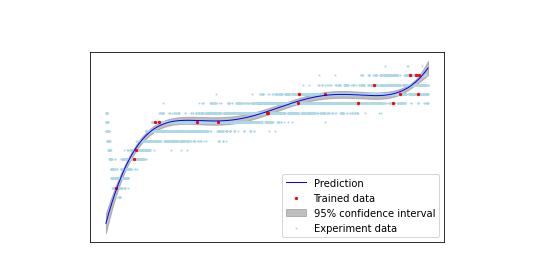

Number of data points used: 22


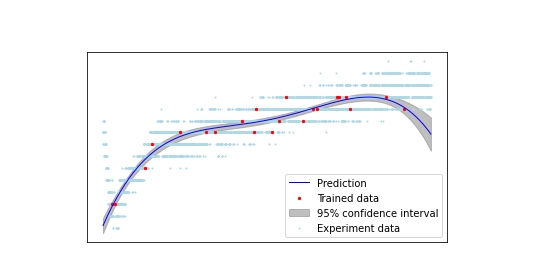

Number of data points used: 24


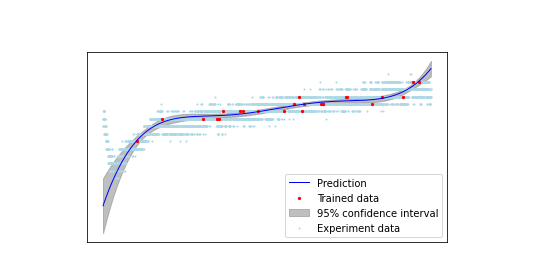

Number of data points used: 26


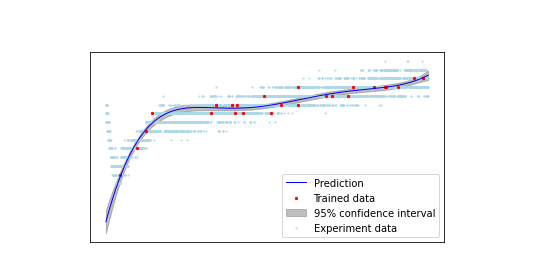

Number of data points used: 28


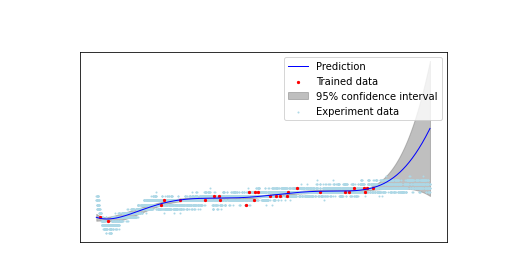

Number of data points used: 30


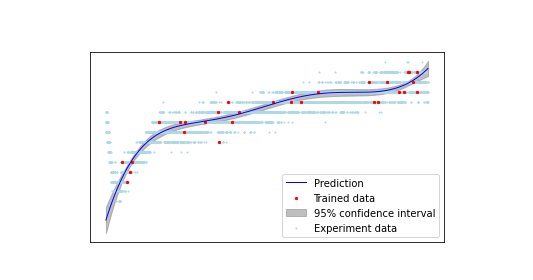

Number of data points used: 33


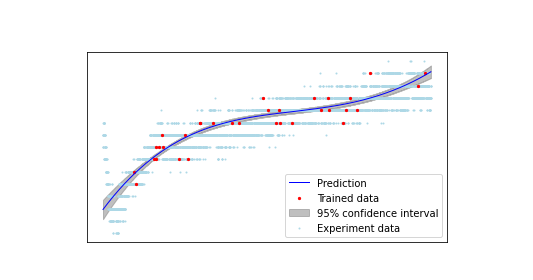

Number of data points used: 37


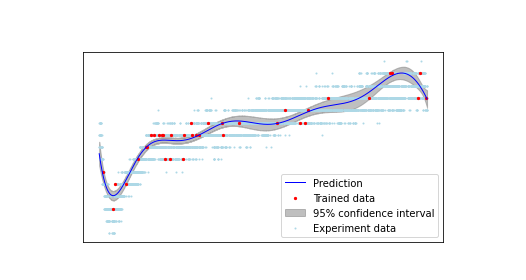

Number of data points used: 40


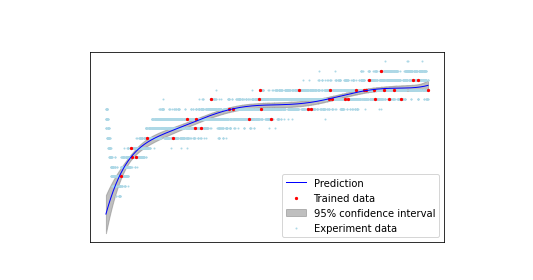

Number of data points used: 45


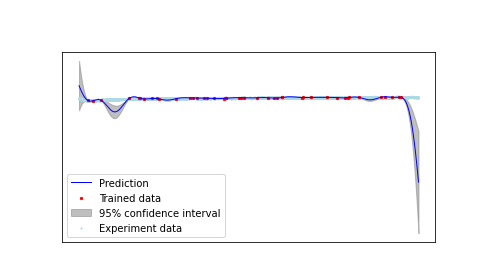

Number of data points used: 50


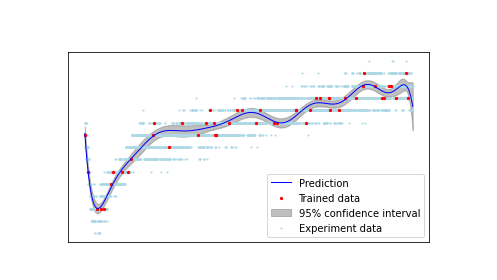

Number of data points used: 60


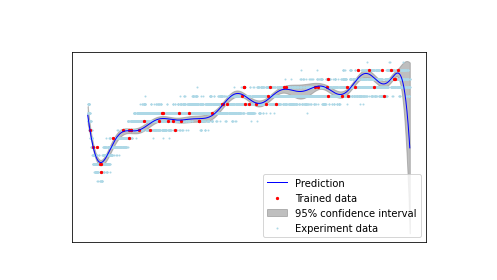

Number of data points used: 80


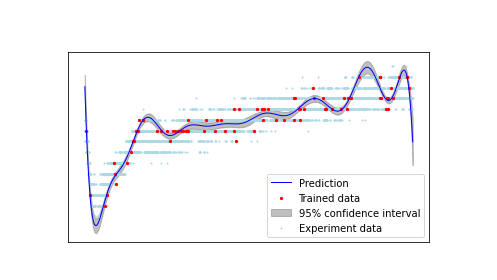

Number of data points used: 100


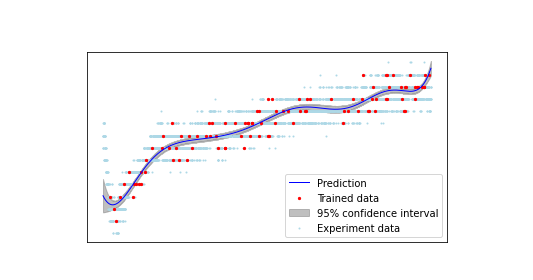

Number of data points used: 200


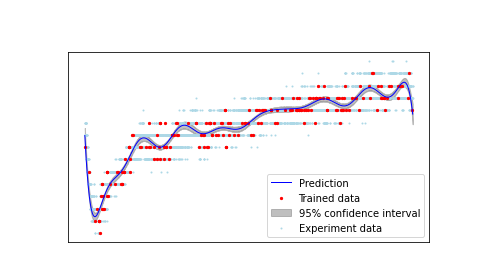

Number of data points used: 250


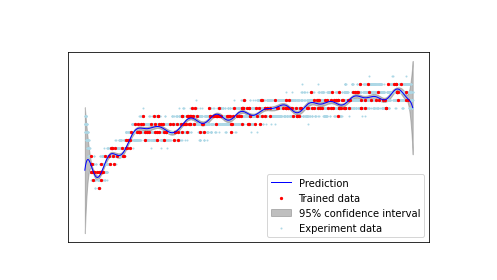

Number of data points used: 300


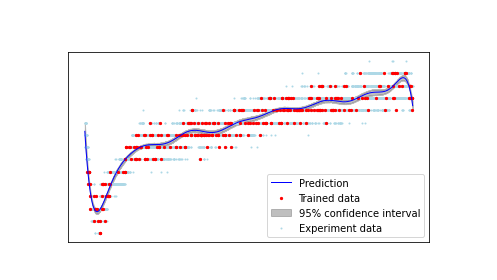

Number of data points used: 400


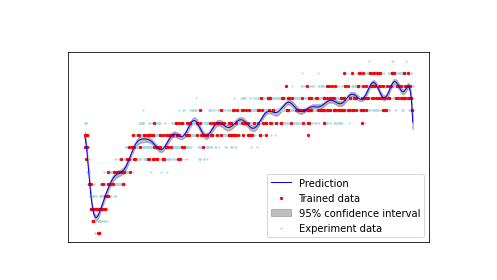

Number of data points used: 500


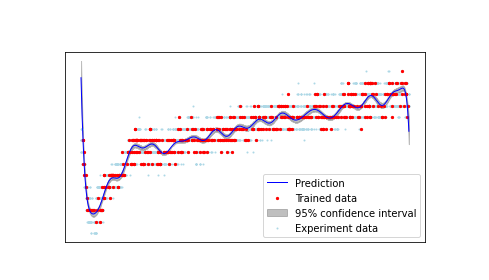

Number of data points used: 600


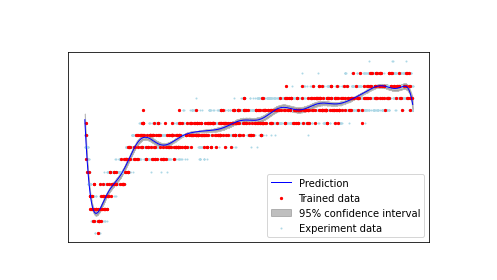

Number of data points used: 700


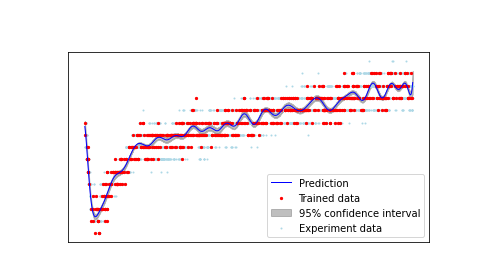

Number of data points used: 800


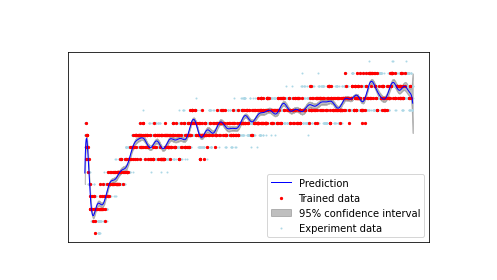

Number of data points used: 1000


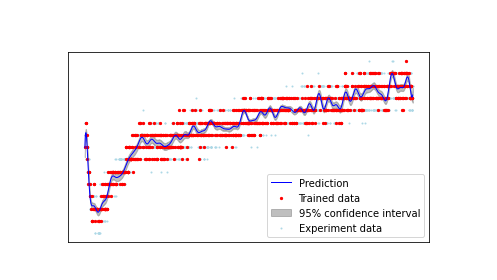

Number of data points used: 1200


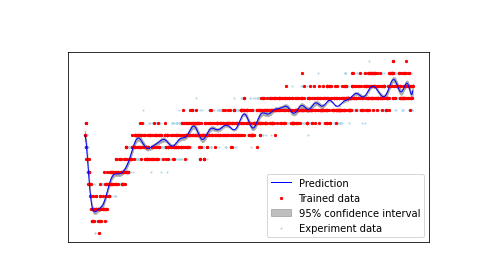

Number of data points used: 1400


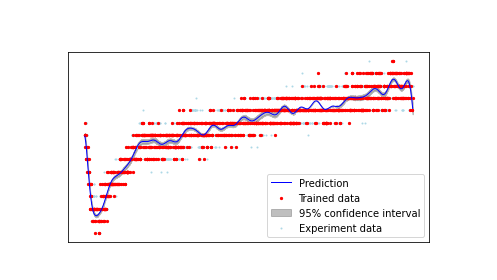

Number of data points used: 1700


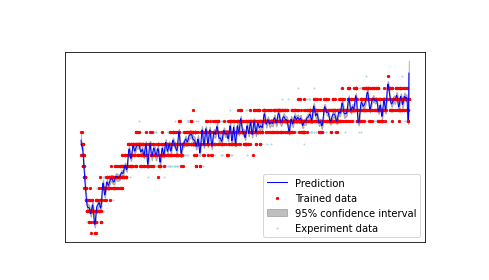

Number of data points used: 2000


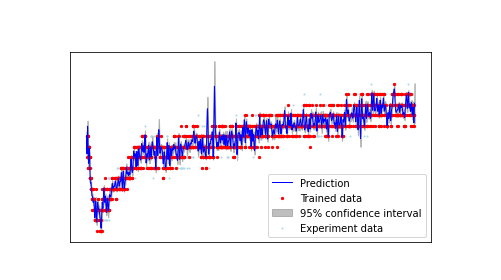

Number of data points used: 2500


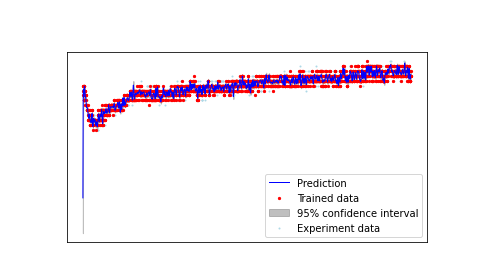


Mean squared error


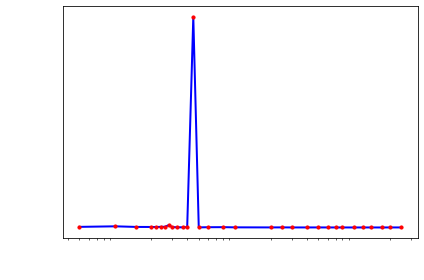

Log marginal likelihood


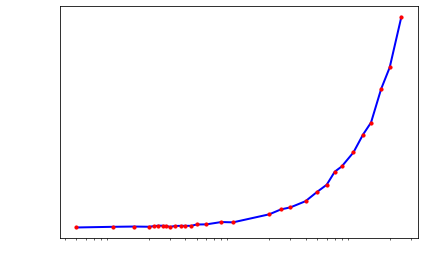

In [45]:
# Ploting ucb value from ei aquisition equation 
# with different amount of data with lsb max
# This demo has not 

# Kernel setting
length_scale_bounds_MAX = 1000
length_scale_bounds_MIN = 1e-4

for NUM_OF_DATA_POINTS in (20,30,40,50,60,80,100,120,150,200,300,500):
    x_loop = np.arange(0,5000,int(5000/NUM_OF_DATA_POINTS))
    X = x_normal[x_loop].reshape(x_loop.size)
    Y = y_normal[x_loop]
    X = X.reshape(x_loop.size,1)
    
    kernel = 1.0 * RBF(length_scale=20,length_scale_bounds=(length_scale_bounds_MIN, length_scale_bounds_MAX)) + WhiteKernel(noise_level=0.00000001)
    gp = GaussianProcessRegressor(kernel=kernel,alpha=0.0).fit(X, Y)
    y_mean, y_cov = gp.predict(X_[:, np.newaxis], return_cov=True)

    # Get ucb prediction
    ucb_y_min = ucb(X_, gp, 0.1, 5)
    X_min = np.argmin(ucb_y_min[-1])
    # ucb_y_min = ucb_y_min[-1]
    # ei_value = ei(X_, gp, max(y_normal))
    # print(ei_value)
    # rucb_value = rucb_balance(X_, gp, 0.1,5)
    
    print('Number of data points used:', x_loop.size)
    # Find lsb max by the function 
    length_scale_bounds_MAX = find_lsb_max(x_normal ,y_normal,X,X_,Y)
    print('Length scale bound max =',length_scale_bounds_MAX)
    print ('Average absolute error:',
    np.format_float_scientific(np.mean(np.absolute(y_normal-y_mean)),precision=5))
    print ('Average percentage error:',
    np.format_float_positional(np.mean(np.absolute((y_normal-y_mean)/y_normal*100)),precision=4),'%')
    ucbplot(X,Y,X_, y_mean,ucb_y_min)
    plot(x_normal ,y_normal, X,X_,y_mean,Y,y_cov)
